 # Problem 1

 ## Part (a)

$P(k + 1) = \frac{p \times (n-k)}{(k+1)(1-p)} \times P(k)$

 ## Part (b)

In [ ]:
NextTerm <- (prev, p, n, k) {
    return(((p*(n-k))/((k+1)*(1-p)))*prev) #return the formula
}

RecursiveBinomial <- (m,n,k) {
    Pn0 <- 1 # the coefficient where k = 0 is always 1.
    Pnn <- 1 # the coefficient where k = n is always 1.
    
    if (k <= n) {
        for k in (n:k) {
            
        }
    }
    
    else {
        for k in (0:k) {
            
        }
        
    }
    
    
}

 # Problem 2

 ## Part (a)

The CDF of a single exponential distribution is $F(x) = 1 - e^{-\lambda x}$. 

Using the symmetry of the uniform dis

In [27]:
DoubleExponential <- function(lambda, n_iters) {
    
    x <- list()
    
    sign <- runif(n_iters) #initialize a random uniform to choose sign
    val <- runif(n_iters) #initialize a random uniform to generate value
    
    for (i in (1:n_iters)) {
        
    if (sign[i] > 0.5) {
        x[i] <- (2.0/lambda)*log(abs(0.5 - val[i])) 
    }
    else if (sign[i] < 0.5) {
        x[i] <- -(2.0/lambda)*log(abs(0.5 - val[i]))   
    }
    }
    return (as.numeric(x))
}

 ## Part (b)

In [66]:
IterStandardDeviation <- function(dist_func, param_range, n_iters) {
    
    sd_list <- list()
    
    for (i in (1:length(param_range))) {
        sd_list[i] <- sd(dist_func(param_range[i], n_iters))
    }
    return(as.numeric(sd_list))
}

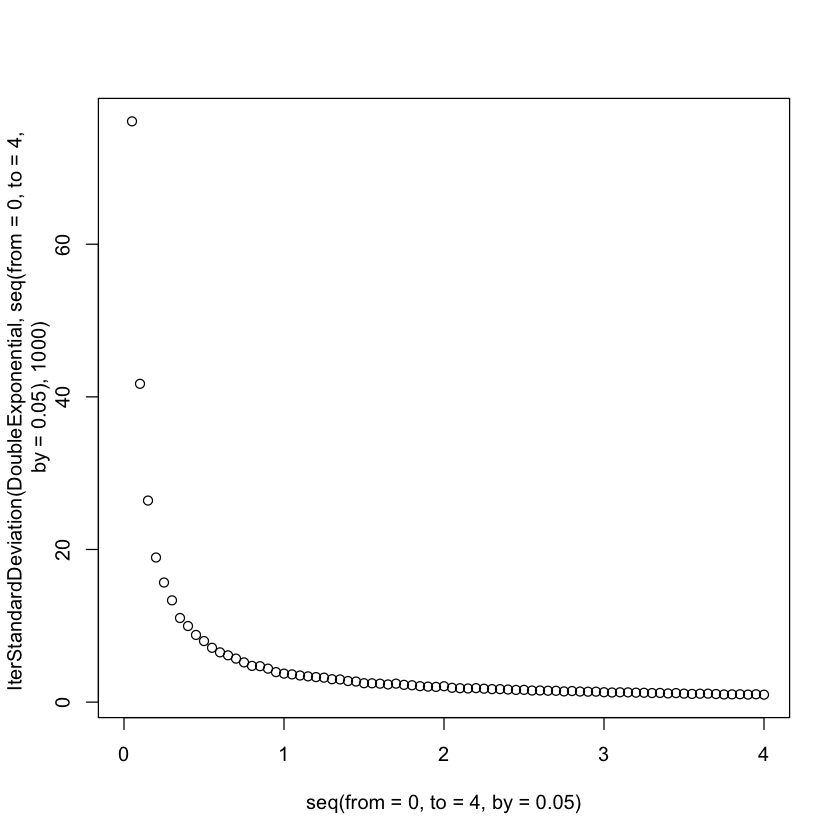

In [70]:
plot(seq(from = 0, to = 4, by = 0.05),IterStandardDeviation(DoubleExponential, seq(from = 0, to = 4, by = 0.05), 1000))

It looks like choosing $\lambda \approx 4$ gets us a standard deviation of 1.

In [54]:
sd(DoubleExponential(4.0,1000))
sd(rnorm(1000))

[1] 0.9812686

[1] 1.00214

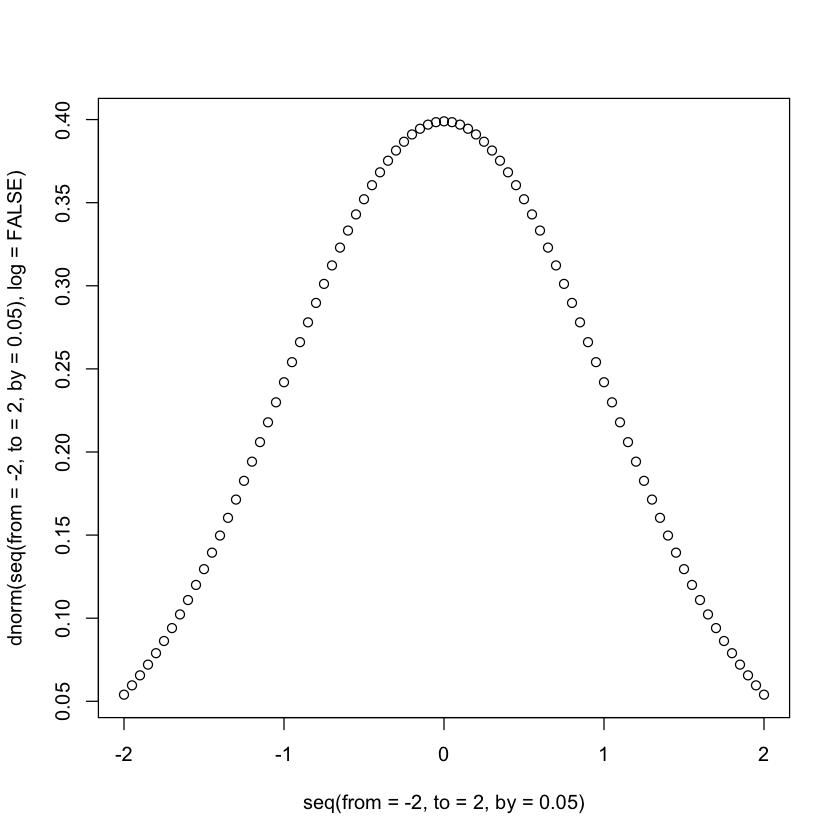

In [80]:
plot(seq(from = -2, to = 2, by = 0.05),dnorm(seq(from = -2, to = 2, by = 0.05),log = FALSE))

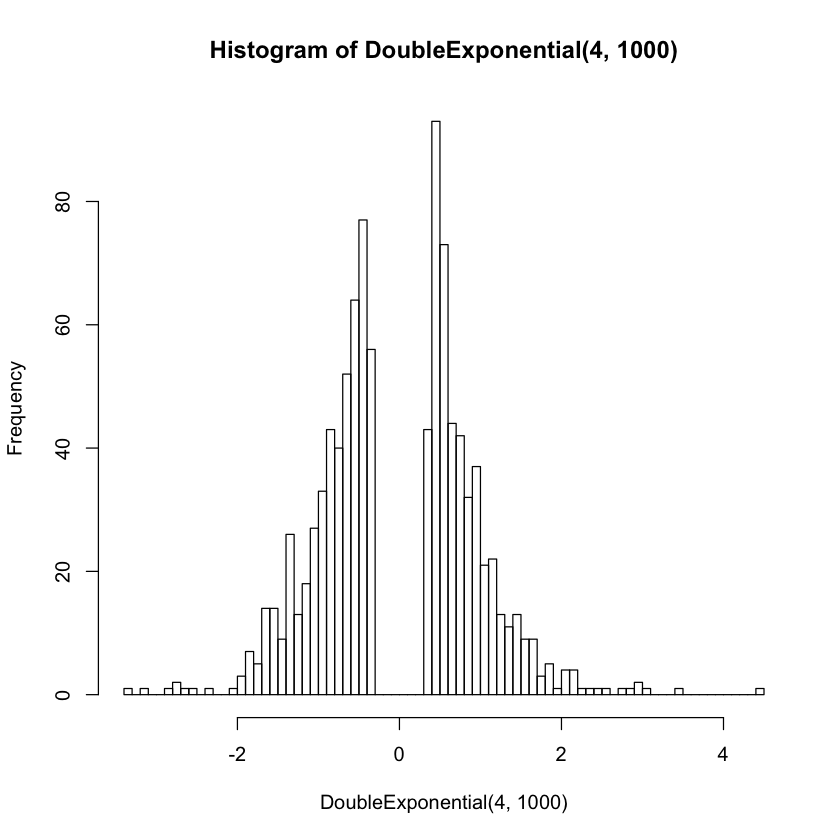

In [81]:
hist(DoubleExponential(4.0, 1000), breaks = 100)

In [88]:
#install.packages("distr", repos="http://cran.rstudio.com/")

library(distr)

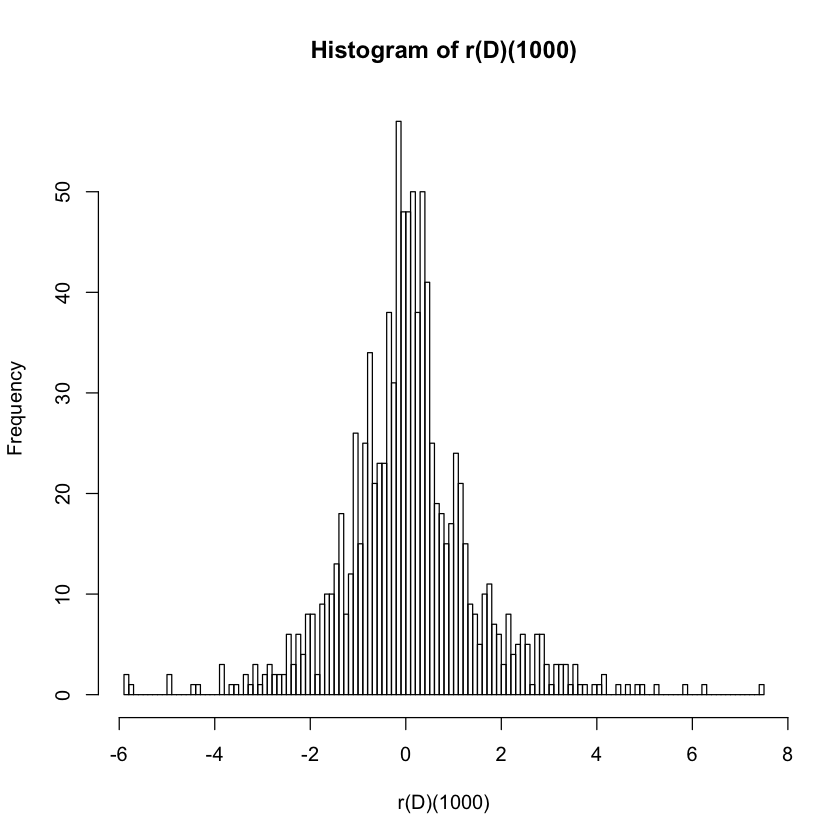

In [95]:
D <- DExp(rate = 1)
hist(r(D)(1000), breaks = 100)

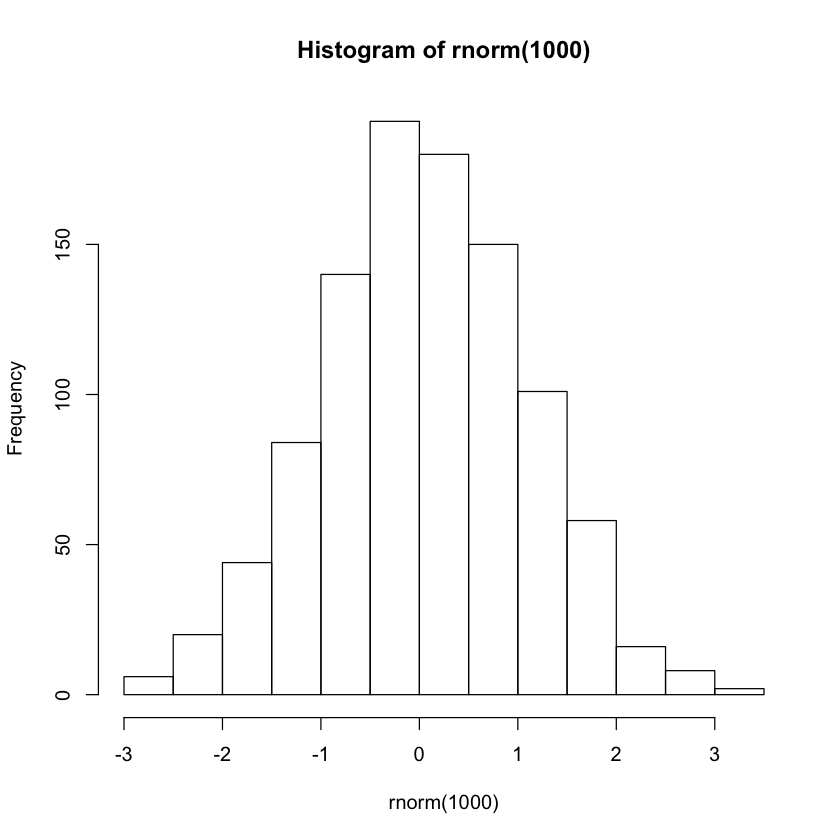

In [82]:
hist(rnorm(1000))

 ## Part (c)

In [191]:
MaskingDraw <- function(maskpdf, goalpdf, prange = c(-10,10), by = 0.01) {
    
    grid <- seq(min(prange),max(prange), by)
    
    c <- max((goalpdf(grid))/(maskpdf(grid)))
    
    mask_draw <- maskpdf(1)
    
    decision_draw <- (goalpdf())/(maskpdf(grid)*c)
    
    return(c)
}

In [192]:
MaskingDraw(dcauchy, dnorm, prange = c(-1,1))

[1] 1.520347

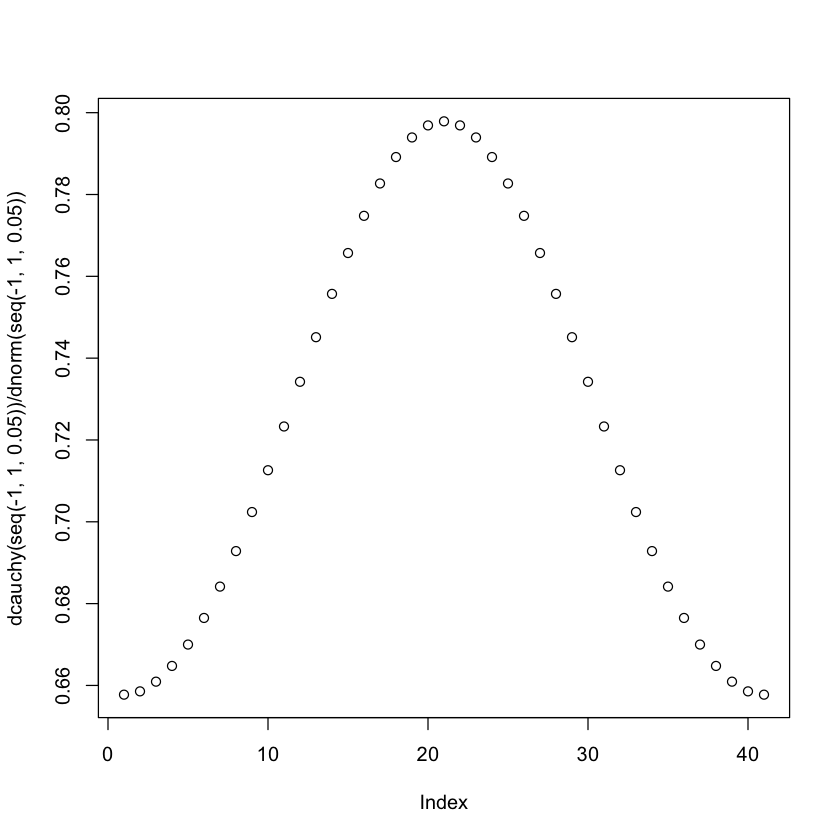

In [117]:
plot(dcauchy(seq(-1,1,0.05))/dnorm(seq(-1,1,0.05)))

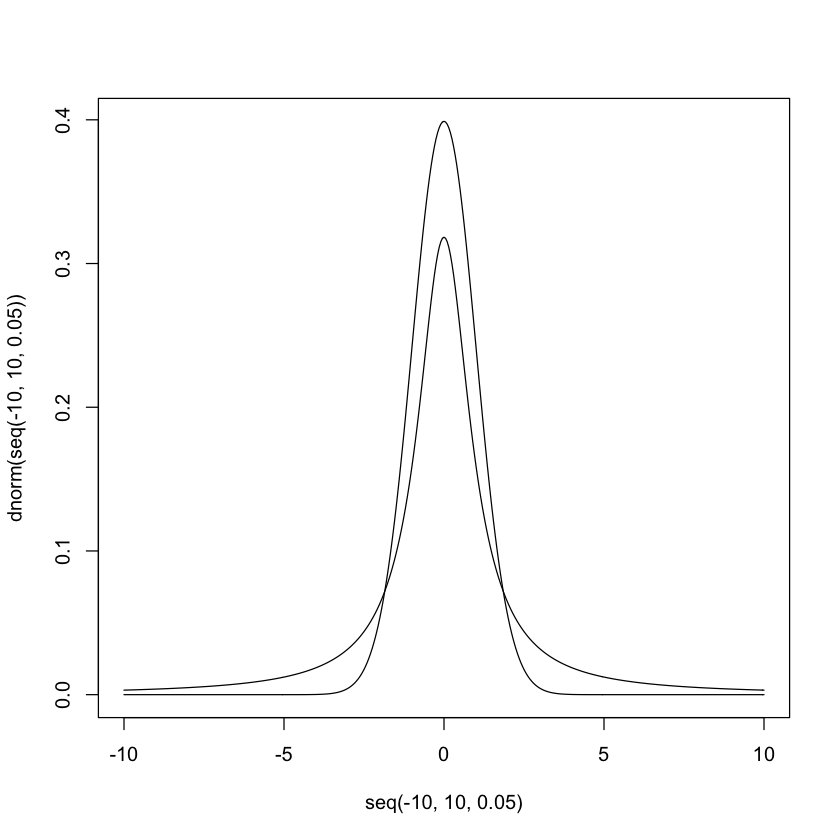

In [129]:
plot(seq(-10,10,0.05),dnorm(seq(-10,10,0.05)), type = 'l')
par(new = T)
lines(seq(-10,10,0.05),dcauchy(seq(-10,10,0.05)), type = 'l')
par(new = F)

 # Problem 3

In [60]:
MapPDF <- function(u, alpha, theta) { 
    #
    # Maps uniforms to a new pdf as described in problem 3:
    #
    # f(x) = alpha*x^(\theta)
    #
    # Args:
    #    u: The input uniform that is to be mapped
    #    alpha: the 'alpha' parameter in the pdf definition
    #    theta: the 'theta parameter in the pdf definition
    # Returns:
    #    out: a float of the mapped uniform
    
    return(((u*(theta + 1))/alpha)^(1/theta))
    }

We are taking the function $x = (\frac{u(\theta + 1)}{\alpha})^{\frac{1}{\theta}}$

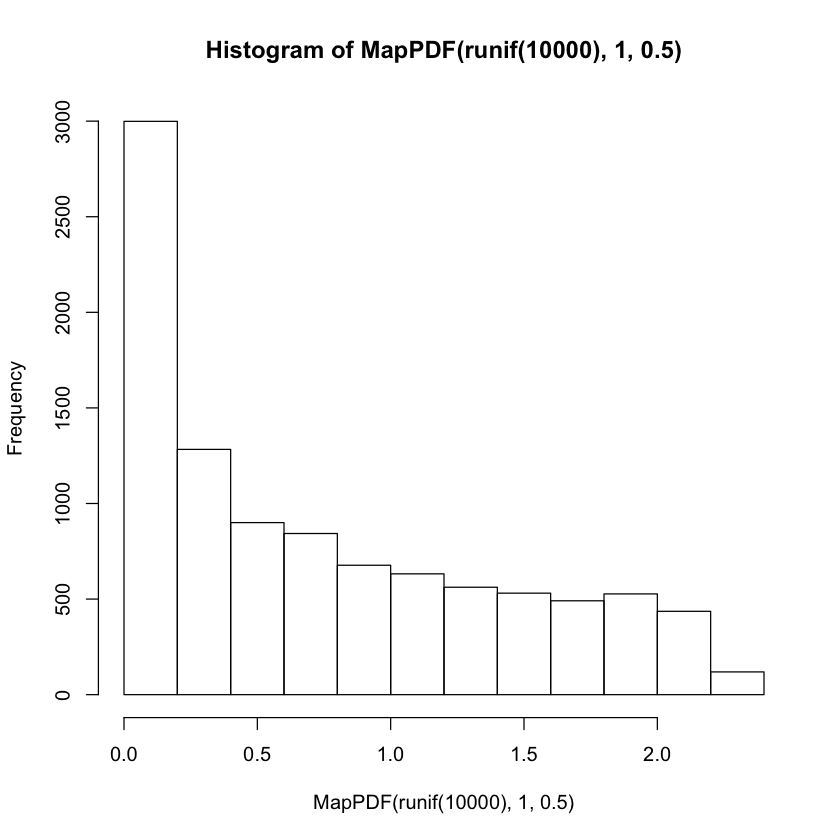

In [71]:
hist(MapPDF(runif(10000), 1,0.5))

 # Problem 4

In [177]:
pdf <- function(x, theta, c = 1) { 
    #
    # Evaluates the PDF in problem 4
    #
    # Args:
    #    x: point to evaluate pdf 
    #    theta: phase offset in input funciton
    #    c: normalization constant, defaults to 1
    #
    # Returns:
    #    pdf(x): pdf evaluated at x
    
    
    #conditionals to restrict x to the working range of the function.
    if (x < 0) {
        stop('x < 0')
    }
    
    else if (x > 2*pi) {
        stop('x > 2*pi')
    }
    
    else if (theta < -pi) {
        stop('theta < -pi')
    }
    
    else if (theta > pi) {
        stop('theta > pi')
    }
    
    else {
        
    return((1 - cos(x - theta))/(c))
                
    }
    
}

StochasticIntegral <- function(pdf, prange = c(0,2*pi), n_iters) {
    
    #
    # Performs stochastic (monte carlo) integration
    #
    # Args:
    #    pdf: the function to integrate
    #    prange: the range of x values to integrate over
    #    n_iters: number of draws to perform to evaluate the integral
    #
    # Returns:
    #    integral: the stochastic estimate of the integral
    
    V <- max(prange) - min(prange)
    hold <- c() #hold 
    i <- 0
    for (U in runif(n_iters)*V) {
        i <- i + 1
        hold[i] <- pdf(U, 0)  
    }
    
     return((sum(hold)/n_iters)*V)
}

In [179]:
StochasticIntegral(pdf, n_iters = 10000)

[1] 6.266037

Looks like the normalization constant needs to be $2\pi$

  ## Part (a)

Warning message:
In if (x < 0) {: the condition has length > 1 and only the first element will be usedWarning message:
In if (x > 2 * pi) {: the condition has length > 1 and only the first element will be used

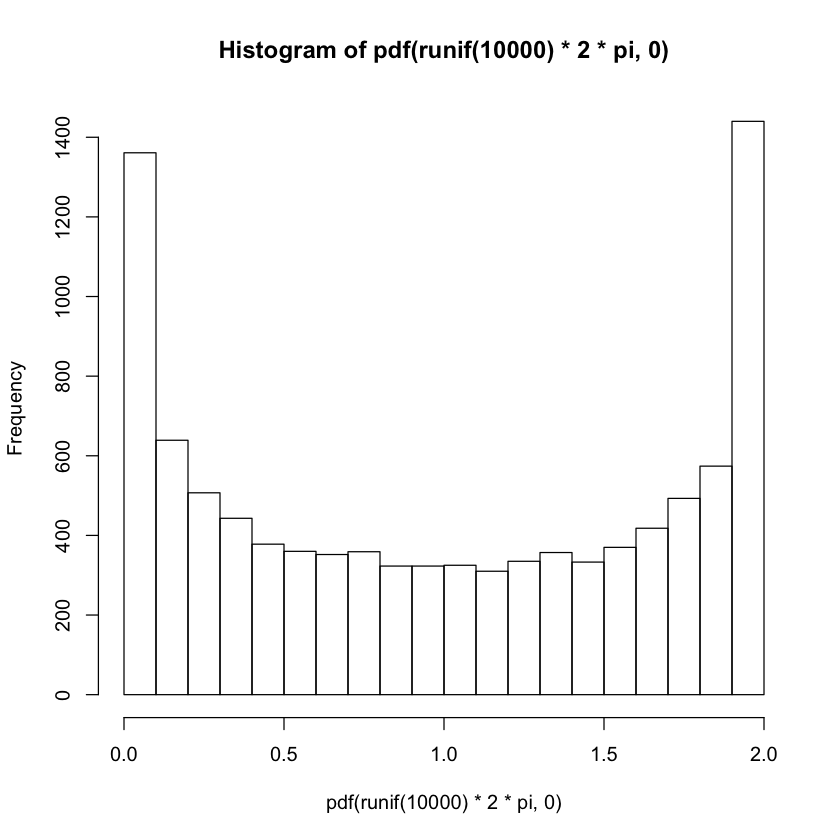

In [139]:
hist(pdf(runif(10000)*2*pi,0))

  ## Part (b)

  ## Part (c)

  ## Part (d)

  ## Part (e)